In [1]:
# %%
from generate_mdps import generate_datsets
from dataset import MDPDataset, AllNodeFeatures, InMemoryMDPDataset, TransitionsOnEdge
from experiment import Experiment
from MDP_helpers import calculate_gap, multiclass_recall_score

# %%
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import numpy as np

import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch_geometric.nn.models import GCN, GAT
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import random_split
from collections import defaultdict
from sklearn.metrics import recall_score, accuracy_score
from sklearn.model_selection import KFold
from torch.utils.data import SubsetRandomSampler

from time import time
from tqdm import tqdm

torch.cuda.manual_seed(12345)
np.random.seed(54321)

import pickle

/home/james/virtual_envs/csiro_venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
from collections import defaultdict

In [2]:
N_datasets = 100

N_sites = 6
N_species = 20
K = 8
N_states = 3**N_sites

recreate_data = False

In [4]:
print(f"MDP Data: N_states: {N_states}")
dataset_folder = f"Reserve_MDP_{N_states}_{K}"
generate_datsets(N_sites, N_species, K, N_datasets, remove_previous=recreate_data, folder=dataset_folder)

MDP Data: N_states: 729
Deleting folder  datasets/Reserve_MDP_729_8/raw
Generating 100 MDPs with 729 states and 6 actions 



100%|██████████| 100/100 [02:09<00:00,  1.29s/it]


Loading data into dataloader
Data(x=[729, 4380], edges=[2, 10176], k_labels=[729], P=[6, 729, 729], R=[729, 6], V=[729])


In [24]:
results = defaultdict(lambda : defaultdict(list))

Data(x=[729, 4380], edges=[2, 10176], k_labels=[729], P=[6, 729, 729], R=[729, 6], V=[729])
              mean    median       min       max
accuracy  0.055130  0.045953  0.006859  0.138546
gap       0.193112  0.176565  0.061124  0.453355
error     0.123354  0.115214  0.040028  0.257742


Text(0.5, 1.0, 'error')

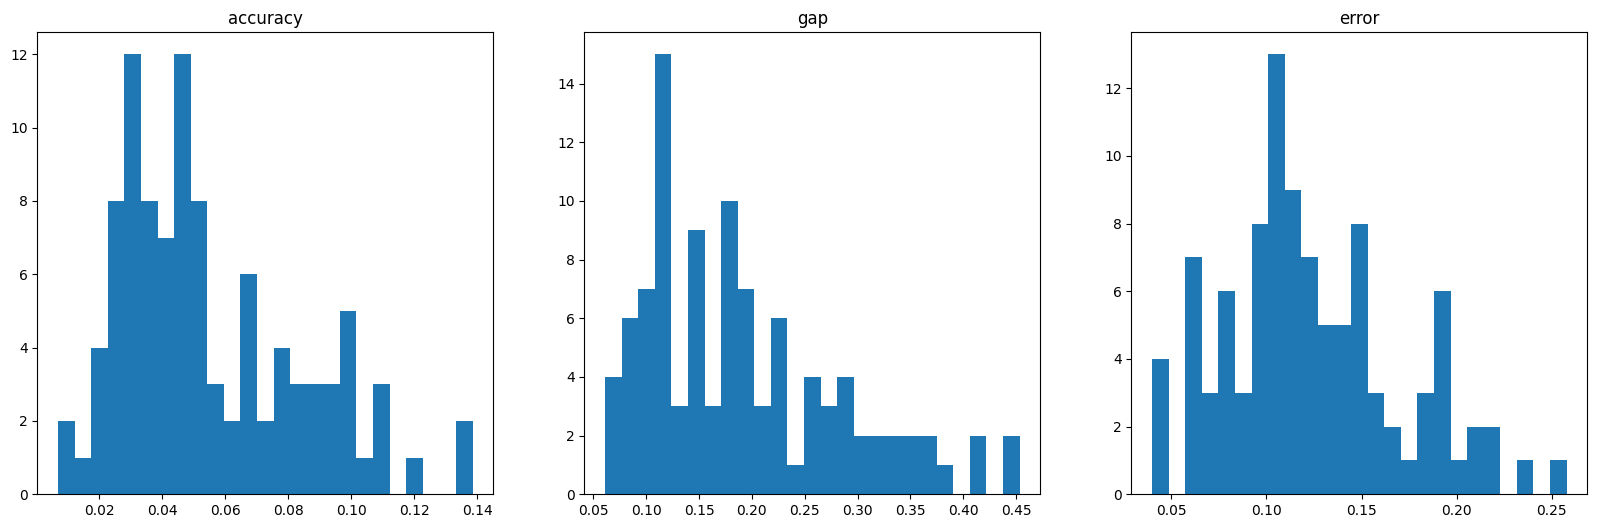

In [25]:
experiment_name = "GCN_accuracy_weighted"
filename = f'Reserve_MDP_{N_states}_{K}_cv5'
pre_transform = AllNodeFeatures()

dataset = InMemoryMDPDataset(f"datasets/{dataset_folder}", pre_transform=pre_transform)
print(dataset[0])
if torch.all(dataset[0].R == dataset[5].R):
    raise Exception("Datasets are likely identical!!")

file = open(f"Results/{experiment_name}/{filename}/model.pckl", "rb")
model = pickle.load(file)
model.to('cpu')

for data in dataset:
    pred = model(
        x = data.x,
        edge_index = data.edges
    )

    pred_k = F.softmax(pred, dim=1).argmax(axis=1)
    g, e = calculate_gap(data.P, data.R, data.V, pred_k, 8, device='cpu')

    results[f"{experiment_name}"]["accuracy"].append(accuracy_score(data.k_labels, pred_k))
    results[f"{experiment_name}"]["gap"].append(g)
    results[f"{experiment_name}"]["error"].append(e)

df = pd.DataFrame()
df["accuracy"] = results[f"{experiment_name}"]["accuracy"]
df["gap"] = results[f"{experiment_name}"]["gap"]
df["error"] = results[f"{experiment_name}"]["error"]

df["gap"] = df["gap"].astype(float)
df["error"] = df["error"].astype(float)

print(df.agg(['mean', "median", "min", "max"]).T)

fig, ax = plt.subplots(ncols=3, figsize=(20, 6))
ax[0].hist(results[f"{experiment_name}"]["accuracy"], bins=25);
ax[1].hist(results[f"{experiment_name}"]["gap"], bins=25);
ax[2].hist(results[f"{experiment_name}"]["error"], bins=25);

ax[0].set_title("accuracy")
ax[1].set_title("gap")
ax[2].set_title("error")

Data(x=[729, 6], edges=[2, 10176], edge_features=[10176, 6], k_labels=[729], P=[6, 729, 729], R=[729, 6], V=[729])
              mean    median       min       max
accuracy  0.049712  0.045267  0.010974  0.135802
gap       0.211971  0.182907  0.062721  1.012537
error     0.136609  0.125196  0.051918  0.992673


Text(0.5, 1.0, 'error')

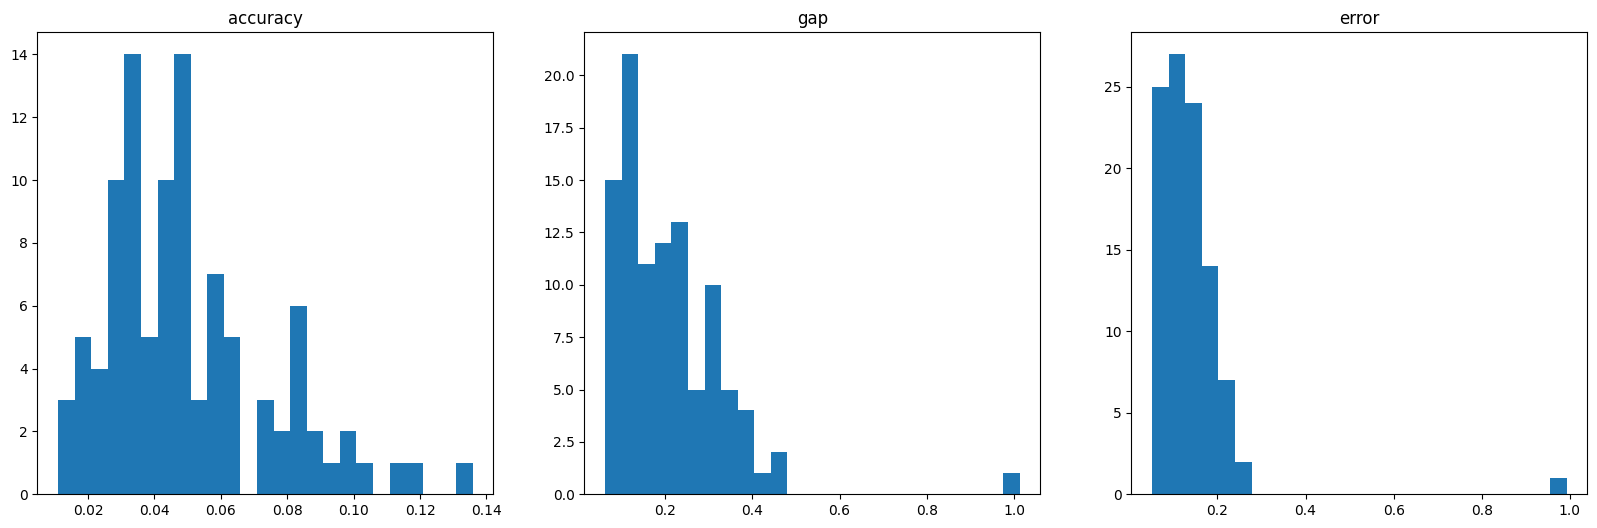

In [26]:
experiment_name = "GAT_weighted_edge"
filename = f'Reserve_MDP_{N_states}_{K}'
pre_transform = TransitionsOnEdge()

dataset = InMemoryMDPDataset(f"datasets/{dataset_folder}", pre_transform=pre_transform)
print(dataset[0])
if torch.all(dataset[0].R == dataset[5].R):
    raise Exception("Datasets are likely identical!!")

file = open(f"Results/{experiment_name}/{filename}/model.pckl", "rb")
model = pickle.load(file)
model.to('cpu')

for data in dataset:
    pred = model(
        x = data.x,
        edge_index = data.edges
    )

    pred_k = F.softmax(pred, dim=1).argmax(axis=1)
    g, e = calculate_gap(data.P, data.R, data.V, pred_k, 8, device='cpu')

    results[f"{experiment_name}"]["accuracy"].append(accuracy_score(data.k_labels, pred_k))
    results[f"{experiment_name}"]["gap"].append(g)
    results[f"{experiment_name}"]["error"].append(e)

df = pd.DataFrame()
df["accuracy"] = results[f"{experiment_name}"]["accuracy"]
df["gap"] = results[f"{experiment_name}"]["gap"]
df["error"] = results[f"{experiment_name}"]["error"]

df["gap"] = df["gap"].astype(float)
df["error"] = df["error"].astype(float)

print(df.agg(['mean', "median", "min", "max"]).T)

fig, ax = plt.subplots(ncols=3, figsize=(20, 6))
ax[0].hist(results[f"{experiment_name}"]["accuracy"], bins=25);
ax[1].hist(results[f"{experiment_name}"]["gap"], bins=25);
ax[2].hist(results[f"{experiment_name}"]["error"], bins=25);

ax[0].set_title("accuracy")
ax[1].set_title("gap")
ax[2].set_title("error")

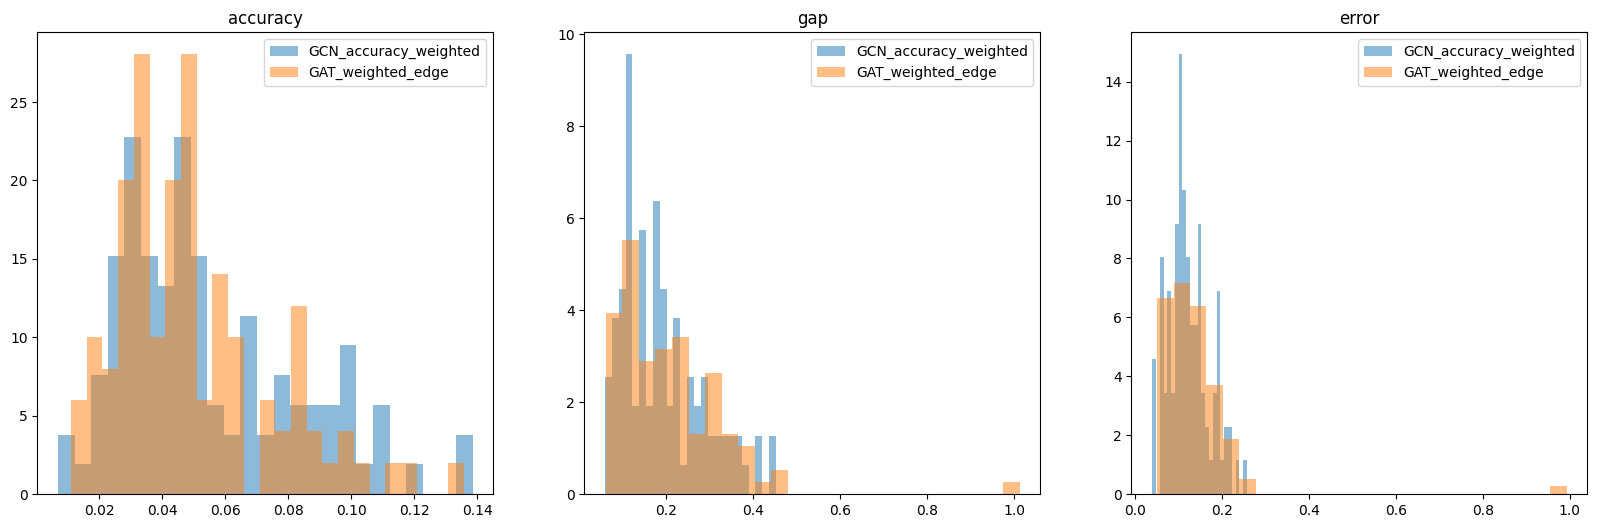

In [29]:
fig, ax = plt.subplots(ncols=3, figsize=(20, 6))
ax[0].hist(results["GCN_accuracy_weighted"]["accuracy"], bins=25, alpha=0.5, density=True);
ax[1].hist(results["GCN_accuracy_weighted"]["gap"], bins=25, alpha=0.5, density=True);
ax[2].hist(results["GCN_accuracy_weighted"]["error"], bins=25, alpha=0.5, density=True);

ax[0].hist(results["GAT_weighted_edge"]["accuracy"], bins=25, alpha=0.5, density=True);
ax[1].hist(results["GAT_weighted_edge"]["gap"], bins=25, alpha=0.5, density=True);
ax[2].hist(results["GAT_weighted_edge"]["error"], bins=25, alpha=0.5, density=True);

ax[0].set_title("accuracy")
ax[1].set_title("gap")
ax[2].set_title("error")

ax[0].legend(["GCN_accuracy_weighted", "GAT_weighted_edge"])
ax[1].legend(["GCN_accuracy_weighted", "GAT_weighted_edge"])
ax[2].legend(["GCN_accuracy_weighted", "GAT_weighted_edge"])

Text(0.5, 1.0, 'Error')

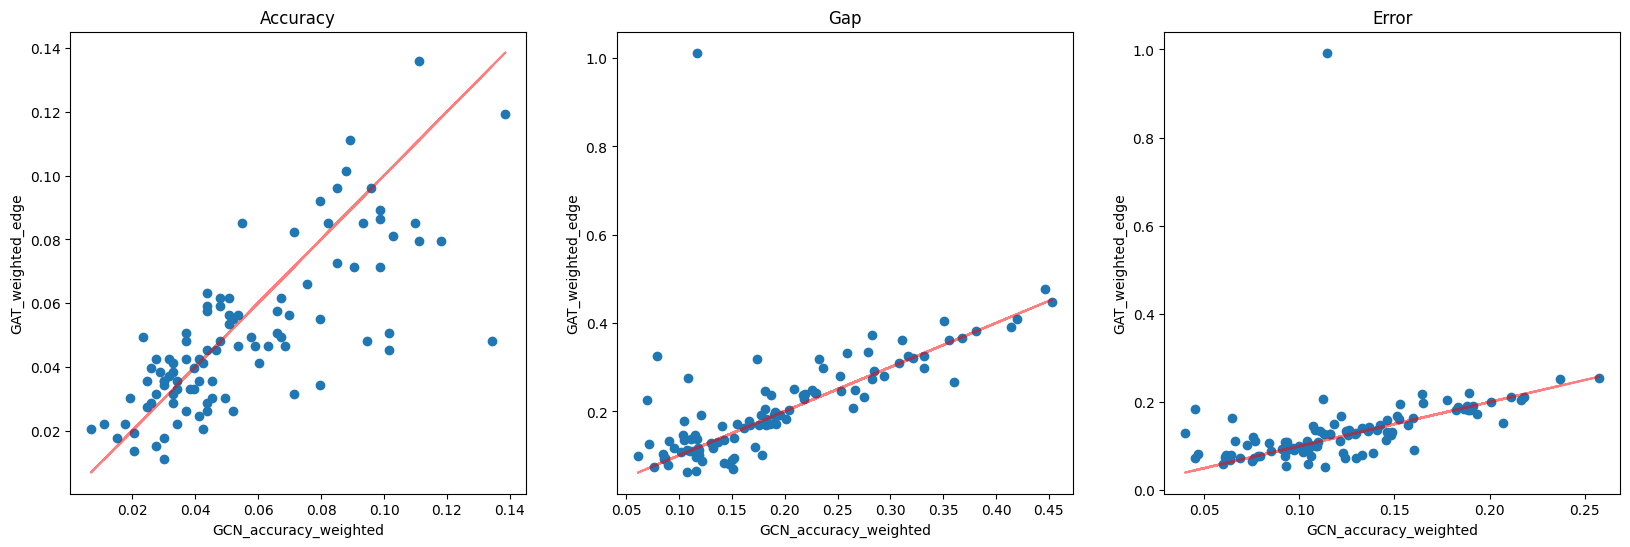

In [47]:
fig, ax = plt.subplots(ncols=3, figsize=(20, 6))
ax[0].scatter(results["GCN_accuracy_weighted"]["accuracy"], results["GAT_weighted_edge"]["accuracy"])
ax[0].plot(results["GCN_accuracy_weighted"]["accuracy"], results["GCN_accuracy_weighted"]["accuracy"], c="r", alpha=0.5)
ax[1].scatter(results["GCN_accuracy_weighted"]["gap"], results["GAT_weighted_edge"]["gap"])
ax[1].plot(results["GCN_accuracy_weighted"]["gap"], results["GCN_accuracy_weighted"]["gap"], c="r", alpha=0.5)
ax[2].scatter(results["GCN_accuracy_weighted"]["error"], results["GAT_weighted_edge"]["error"])
ax[2].plot(results["GCN_accuracy_weighted"]["error"], results["GCN_accuracy_weighted"]["error"], c="r", alpha=0.5)


ax[0].set_xlabel("GCN_accuracy_weighted")
ax[0].set_ylabel("GAT_weighted_edge")
ax[0].set_title("Accuracy")

ax[1].set_xlabel("GCN_accuracy_weighted")
ax[1].set_ylabel("GAT_weighted_edge")
ax[1].set_title("Gap")

ax[2].set_xlabel("GCN_accuracy_weighted")
ax[2].set_ylabel("GAT_weighted_edge")
ax[2].set_title("Error")

# Sensitivity Analysis

In [59]:
experiment_name = "GCN_accuracy_weighted"
filename = f'Reserve_MDP_{N_states}_{K}_cv5'
pre_transform = AllNodeFeatures()

dataset = InMemoryMDPDataset(f"datasets/{dataset_folder}", pre_transform=pre_transform)
print(dataset[0])
if torch.all(dataset[0].R == dataset[5].R):
    raise Exception("Datasets are likely identical!!")

file = open(f"Results/{experiment_name}/{filename}/model.pckl", "rb")
model = pickle.load(file)
model.to('cpu')

Data(x=[729, 4380], edges=[2, 10176], k_labels=[729], P=[6, 729, 729], R=[729, 6], V=[729])


GCN(4380, 8, num_layers=1)

In [86]:
thresh = 0.05

In [87]:
gap = []
t1_count = []
t2_count = []
mixed_count = []
insensitive_count = []

In [88]:
idx = 0

In [121]:
for idx in tqdm(range(idx, len(dataset))):
    mdp = dataset[idx]

    pred = model(
            x = mdp.x,
            edge_index = mdp.edges
        )

    pred_k = F.softmax(pred, dim=1).argmax(axis=1)
    g, e = calculate_gap(mdp.P, mdp.R, mdp.V, pred_k, 8, device='cpu')

    k_labels = 1*mdp.k_labels
    state_gaps = pd.DataFrame(index = np.arange(N_states), columns = np.arange(K))

    for i in range(N_states):
        k_labels = 1*mdp.k_labels
        for j in range(K):
            k_labels[i] = j
            gap_ij, _ = calculate_gap(mdp.P, mdp.R, mdp.V, k_labels, K)
            state_gaps.loc[i, j] = float(gap_ij)

    sensitivity = pd.DataFrame(index = np.arange(N_states), columns=["Type"])
    n = (state_gaps > thresh).sum(axis=1)

    gap.append(g)
    t1_count.append(sum(n.isin([1, 2])))
    t2_count.append(sum(n.isin([6, 7])))
    mixed_count.append(sum(~n.isin([0, 1, 2, 6, 7])))
    insensitive_count.append(sum(n == 0))
    

100%|██████████| 30/30 [3:11:02<00:00, 382.08s/it]  


In [122]:
df_sensitivity = pd.DataFrame()
df_sensitivity["gap"] = [float(i) for i in gap]
df_sensitivity["t1 count"] = t1_count
df_sensitivity["t2 count"] = t2_count
df_sensitivity["mixed count"] = mixed_count
df_sensitivity["insensitive count"] = insensitive_count

In [123]:
df_sensitivity.to_csv("counts_sensitivity.csv", index=False)

In [2]:
df_sensitivity = pd.read_csv("counts_sensitivity.csv")

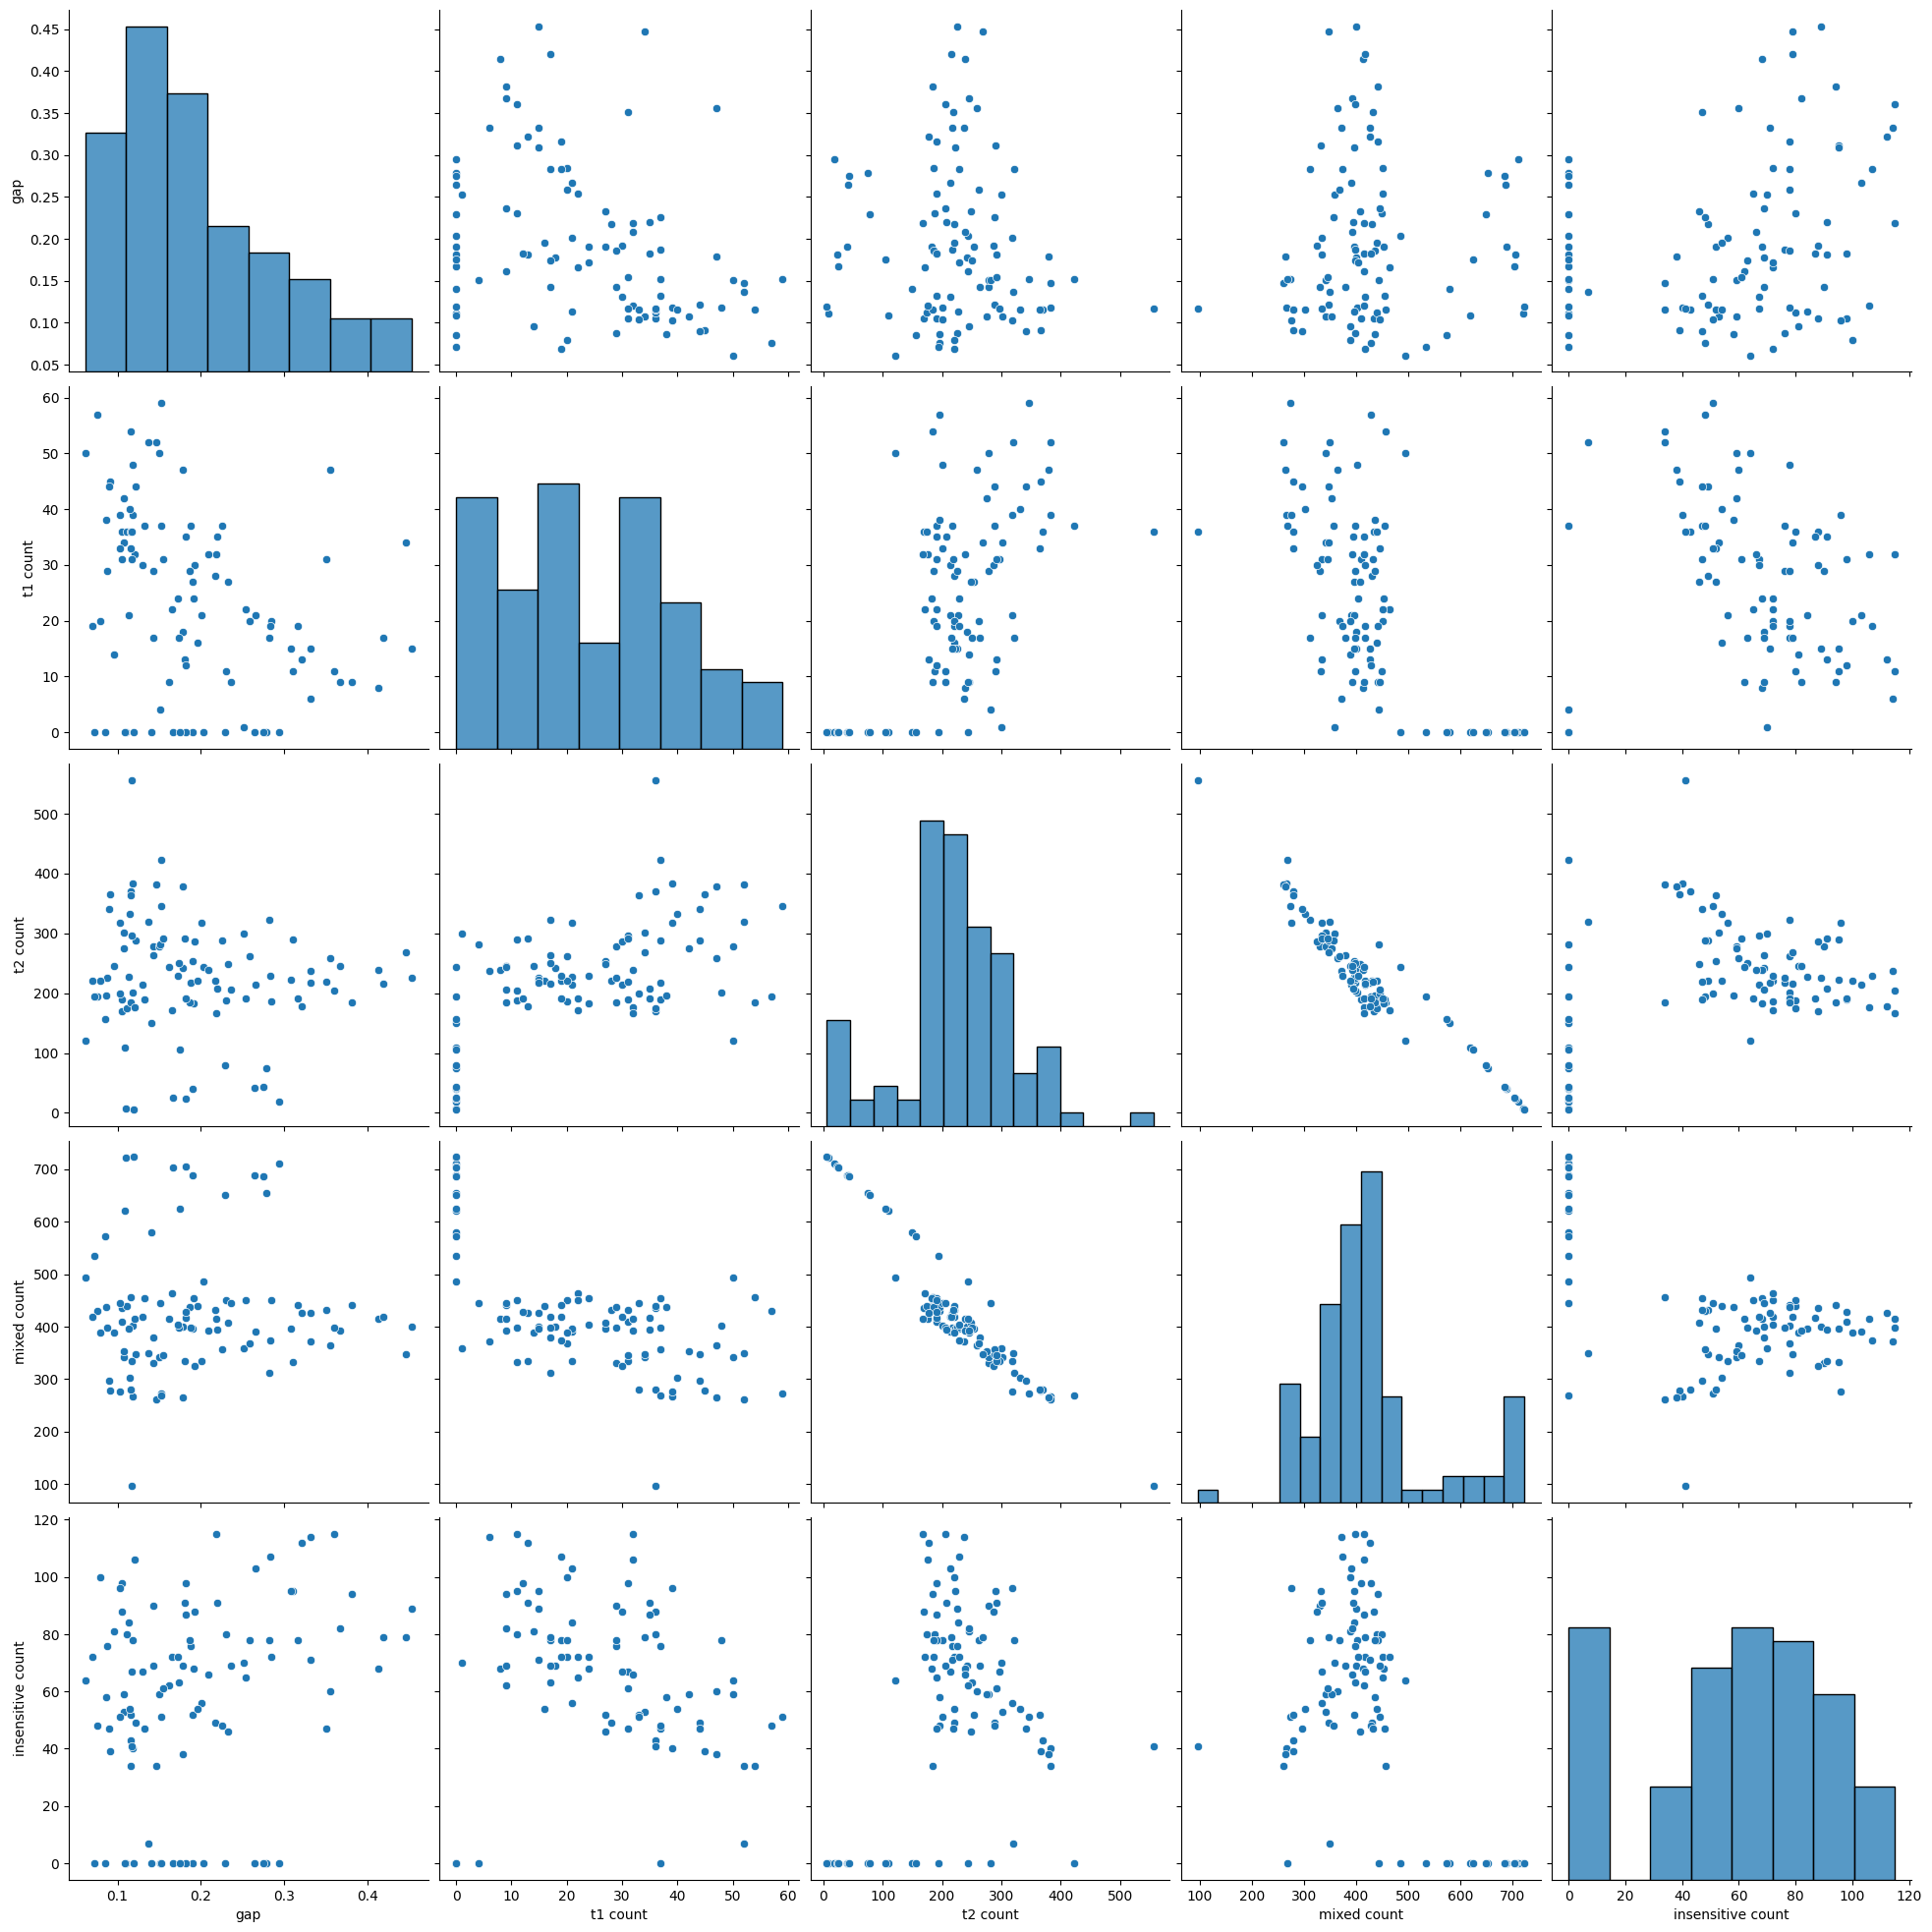

In [3]:
sns.pairplot(df_sensitivity, height=4)

Text(0, 0.5, 'Gap from model')

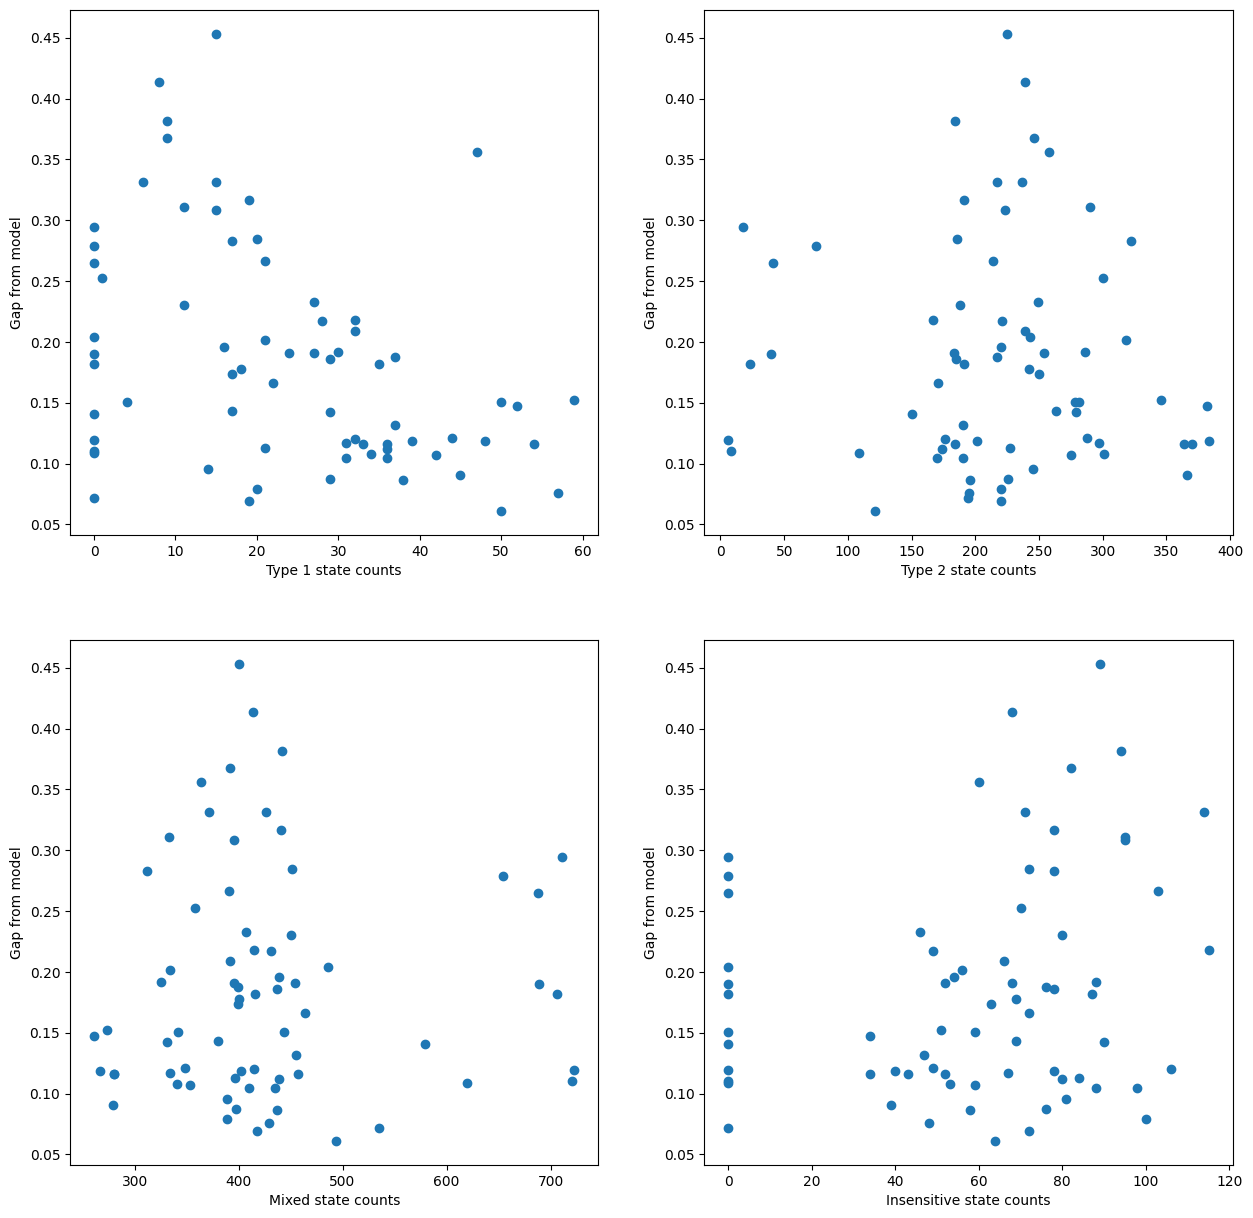

In [118]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))

ax[0][0].scatter(t1_count, gap)
ax[0][0].set_xlabel("Type 1 state counts")
ax[0][0].set_ylabel("Gap from model")

ax[0][1].scatter(t2_count, gap)
ax[0][1].set_xlabel("Type 2 state counts")
ax[0][1].set_ylabel("Gap from model")

ax[1][0].scatter(mixed_count, gap)
ax[1][0].set_xlabel("Mixed state counts")
ax[1][0].set_ylabel("Gap from model")

ax[1][1].scatter(insensitive_count, gap)
ax[1][1].set_xlabel("Insensitive state counts")
ax[1][1].set_ylabel("Gap from model")